In [75]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()  #multilabelled dataset, not single labelled


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_df.columns


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
train_df.shape  #there are many number of columns, this helps decide models and vectorization later

(159571, 8)

In [6]:
train_df["comment_text"].iloc[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [7]:
train_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum()  #cheked label distribution here

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

CLEANING TEXT DATA TO MAKE IT CONSISTENT

In [8]:
train_df["comment_text"].head()  #identify the column we will clean

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [82]:
train_df['clean_text'] = train_df['comment_text'].str.lower()  #convert all the comments into lowercase, this reduces the vocabulary size and incrases the model consistency
test_df["clean_text"] = test_df["comment_text"].str.lower()


In [10]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"""\nmore\ni can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


REMOVE THE URLS

In [83]:

train_df["clean_text"] = train_df["clean_text"].apply(
    lambda x: re.sub(r"http\S+|www\S+", "", x)
)

test_df["clean_text"] = test_df["clean_text"].apply(
    lambda x: re.sub(r"http\S+|www\S+", "", x)
)

# What we did
# Removed URLs from comments

# Why
# URLs add noise
# They don’t indicate toxicity meaningfully

# How it’s used
# Prevents model from learning useless patterns

1. The Regex Pattern (r"http\S+|www\S+")
This is the "search criteria" used to find links.

http\S+: Looks for the characters "http" followed by any characters that are not whitespace (\S+). This catches http:// and https:// links.

|: This is a logical OR.

www\S+: Looks for anything starting with "www" followed by any non-whitespace characters.

2. The Logic
re.sub(pattern, "", x): This tells Python: "Find anything that matches the pattern and replace it with an empty string ("")." Effectively, it deletes the link.

.apply(lambda x: ...): This is a Pandas function that tells the computer to run that deletion logic on every single row in the clean_text column.

REMOVE PUNCTUATION

In [84]:
train_df["clean_text"] = train_df["clean_text"].apply(
    lambda x: re.sub(r"[^a-z\s]", "", x)
)
test_df["clean_text"] = test_df["clean_text"].apply(
    lambda x: re.sub(r"[^a-z\s]", "", x)
)


What we did: 
Kept only lowercase letters and spaces

Why: 
Symbols like !!!, @@@, ### add noise
Words matter more than symbols (for now)

How it’s used: 
Cleaner tokens for later vectorization

REMOVE EXTRA SPACES

In [85]:
train_df["clean_text"] = train_df["clean_text"].apply(
    lambda x: re.sub(r"\s+", " ", x).strip()
)
test_df["clean_text"] = test_df["clean_text"].apply(
    lambda x: re.sub(r"\s+", " ", x).strip()
)


COMPARING THE BOTH BEFORE AND AFTER TEXT

In [14]:
print("Original:")
print(train_df["comment_text"].iloc[0])

print("\nCleaned:")
print(train_df["clean_text"].iloc[0])

Original:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Cleaned:
explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now


REMOVING STOP WORDS USING NLTK

In [15]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRANAV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

we downloaded a predefined English stopword list 

NLTK has a standard list that contains these predefined words

saves us time by writing our own

we will remove these words from our cleaned dataset

In [16]:
stop_words = set(stopwords.words('english')) #calls a predifined list of 179 english stopwords and stores them unique in a set

In [17]:
def remove_stopwords(text):
    words = text.split()
    filtered = [w for w in words if w not in stop_words]
    return ' '.join(filtered)  #splits the text into words, removes the stop words and then joins all the words in the text again


In [18]:
train_df["clean_text"] = train_df["clean_text"].apply(remove_stopwords)

COMPARE BEFORE AND AFTER AGAIN

In [19]:
print("Before:")
print(train_df["comment_text"].iloc[0])

print("\nAfter stopword removal:")
print(train_df["clean_text"].iloc[0])


Before:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

After stopword removal:
explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired


CONVERT CLEANED TEXT INTO NUMERICAL FEATURES

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic used in NLP to rank how important a word is to a specific document within a collection (or "corpus") of documents.

1. Term Frequency (TF)This measures how often a word appears in a specific document.Logic: If "coffee" appears 10 times in a 100-word article, its TF is high.The Problem: Common words like "the" or "and" will always have the highest TF.

2. Inverse Document Frequency (IDF)This measures how "rare" a word is across your entire collection of documents.Logic: If the word "the" appears in every single document, its IDF score is very low (near 0). If the word "espresso" only appears in 2 out of 1,000 documents, its IDF score is very high.

3. The Final Score: $TF \times IDF$A word gets a high score if it appears many times in one document but is rare in others (like "quantum" in a physics paper).A word gets a low score if it appears in almost every document (like "is") or rarely appears at all

In [20]:
train_df[["comment_text", "clean_text"]].head()  #sanity check, "clean_text" is the input for vectorisation


,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


In [21]:
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,2))  #ngram uses unigram and bigram (1,2), unigram sees only one word and makes context out of it, while bigram sees two consecutive words and makes the context: "not good"

In [22]:
x = tfidf.fit_transform(train_df["clean_text"])

# fit → learns vocabulary + IDF weights
# transform → converts text to numbers

In [23]:
x.shape

# Rows = number of comments
# Columns = number of TF-IDF features (words / phrases)

(159571, 5000)

In [24]:
tfidf.get_feature_names_out()[:20]  #shows the unigrams and bigrams back again in human readable form

array(['ability', 'able', 'absence', 'absolute', 'absolutely', 'absurd',
       'abuse', 'abusing', 'abusive', 'academic', 'academy', 'accept',
       'acceptable', 'accepted', 'accepted notable', 'access', 'accident',
       'accordance', 'according', 'accordingly'], dtype=object)

CONVERT TO DATAFRAME ONLY FOR UNDERSTANDING

In [25]:
X_df = pd.DataFrame(
    x.toarray(),
    columns=tfidf.get_feature_names_out()
)

X_df.head()

,ability,able,absence,absolute,absolutely,absurd,abuse,abusing,abusive,academic,...,youre welcome,yourselfgo,yourselfgo fuck,youth,youtube,youve,youve got,ytmndin,ytmndin name,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TRAINING NAIVE BAYES MODEL

In [26]:
y = train_df["toxic"]  #selected the label we want to predict

In [27]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

In [28]:
nb_model = MultinomialNB()

In [29]:
nb_model.fit(x_train, y_train)

MultinomialNB()

In [30]:
y_pred = nb_model.predict(x_val)

In [31]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.9486135046216513
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28859
           1       0.91      0.51      0.66      3056

    accuracy                           0.95     31915
   macro avg       0.93      0.75      0.81     31915
weighted avg       0.95      0.95      0.94     31915



2️⃣ Class-wise breakdown (MOST IMPORTANT)

🔹 Class 0 = Non-toxic

Metric	Value	Meaning

Precision	0.95	When model says “non-toxic”, it’s right 95% of the time

Recall	0.99	It catches almost all non-toxic comments

F1	0.97	Very strong

📌 This is expected — non-toxic is the majority class.

🔹 Class 1 = Toxic (THIS IS THE REAL TEST)

Metric	Value	Meaning

Precision	0.91	When model predicts “toxic”, it’s correct 91% of the time

Recall	0.51	❗ It catches only ~51% of toxic comments

F1	0.66	Decent, but not great

Naive Bayes = strong baseline
but not enough for imbalanced text classification

LOGISTIC REGRESSION MODEL

In [32]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
#"class_weight='balanced'" fixes the toxic comments class imbalance

In [33]:
log_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [34]:
y_pred_log = log_model.predict(x_val)

In [35]:
print("Accuracy:", accuracy_score(y_val, y_pred_log))
print(classification_report(y_val, y_pred_log))

Accuracy: 0.9163089456368478
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     28859
           1       0.54      0.84      0.66      3056

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



You catch many more toxic comments

But you also flag more non-toxic comments as toxic

This is a classic precision–recall tradeoff.

Logistic Regression is doing this:

Being more aggressive

Saying “toxic” more often

Result → more false positives

That hurts precision, but boosts recall.

For toxic comment detection:

👉 High recall is usually more important

Missing toxic content is worse than over-flagging

Naive Bayes achieved higher precision but suffered from low recall, missing a large portion of toxic comments. Logistic Regression significantly improved recall, making it more suitable for moderation-focused use cases despite reduced precision.

TOKENIZATION (INTRO TO DEEP NEURAL NETS)

Tokenization is assigning an integer ID to each and every word

In [55]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")


In [56]:
tokenizer.fit_on_texts(train_df["clean_text"])

CONVERT TO SEQUENCES 

In [57]:
sequences = tokenizer.texts_to_sequences(train_df["clean_text"])

In [58]:
len(tokenizer.word_index)  #how many unique words does the model know

216951

In [59]:
print(train_df["clean_text"].iloc[0])
print(sequences[0])

explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired
[524, 45, 48, 514, 4395, 1, 921, 209, 1885, 1, 1, 2480, 2634, 38, 1010, 1, 2667, 6, 10, 137, 301, 5, 3, 59, 14, 3211]


PADDING

Padding ensures that there are same number of tokens for every sample. we choose the maximum sequence length as 200

In [60]:
max_len = 200

In [61]:
X_train_seq = tokenizer.texts_to_sequences(train_df.loc[y_train.index, "clean_text"])
X_val_seq   = tokenizer.texts_to_sequences(train_df.loc[y_val.index, "clean_text"])


X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)


[45, 23, 982] ---> [45, 23, 982, 0, 0, 0, 0, ...]

In [62]:
X_train_padded.shape

(127656, 200)

INSPECTION OF BEFORE AND AFTER, AFTER PADDING

In [63]:
print("Original:", sequences[0][:10])
print("Padded:  ", X_train_padded[0][:10])

Original: [524, 45, 48, 514, 4395, 1, 921, 209, 1885, 1]
Padded:   [0 0 0 0 0 0 0 0 0 0]


In [64]:
vocab_size = 5000      # same as tokenizer max_words
embedding_dim = 128    # size of word vectors
max_len = 200          # same padding length

BUILDING THE LSTM MODEL

In [65]:
model = Sequential()

In [66]:
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_len
    )
)

c:\Users\PRANAV\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [68]:
model.compile(
    optimizer="adam",  #The Optimizer is the algorithm that updates your model's internal weights to make it smarter
    loss="binary_crossentropy",   #The Loss Function measures how "wrong" the model is.
    metrics=["accuracy"]  #This tells the computer: "While you're training, please also tell me the percentage of correct guesses."
)

In [72]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

In [73]:
history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]  #96 accyracy and 0.11 val_loss
)

Epoch 1/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 97s 48ms/step - accuracy: 0.9802 - loss: 0.0500 - val_accuracy: 0.9515 - val_loss: 0.1948
Epoch 2/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 130s 65ms/step - accuracy: 0.9830 - loss: 0.0438 - val_accuracy: 0.9507 - val_loss: 0.2095


INSPECTING HISTORY USING PREDEFINED KERAS FUNCTION

In [74]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

ACCURACY CURVE

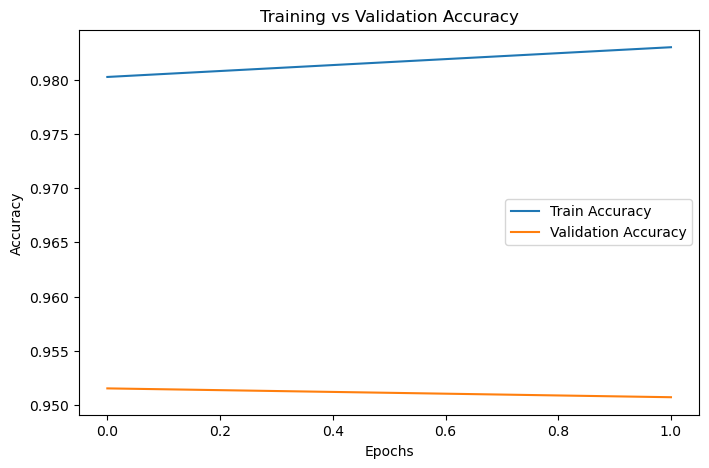

In [76]:
plt.figure(figsize=(8, 5))

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

LOSS CURVE

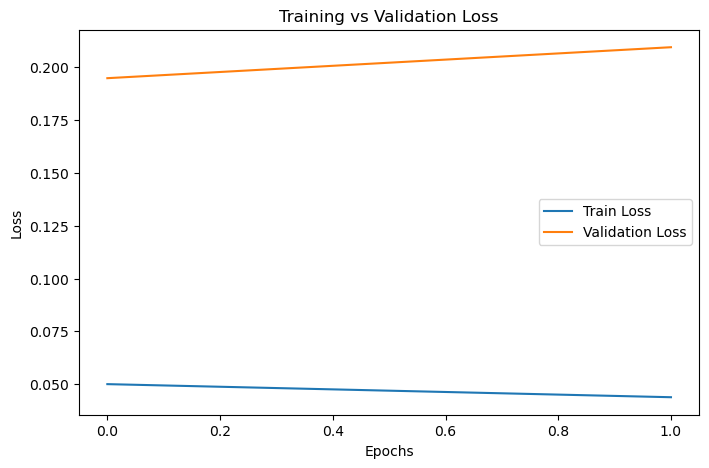

In [77]:
plt.figure(figsize=(8, 5))

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


KAGGLE SUBMISSON

In [80]:
test_df.columns

Index(['id', 'comment_text'], dtype='object')

In [86]:
test_text = test_df["clean_text"]


In [87]:
X_test_seq = tokenizer.texts_to_sequences(test_text)


In [88]:
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)


In [89]:
X_test_padded.shape


(153164, 200)

In [90]:
y_test_pred = model.predict(X_test_padded)


4787/4787 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step


In [91]:
y_test_pred_labels = (y_test_pred > 0.5).astype(int).ravel()


In [92]:
test_df.columns


Index(['id', 'comment_text', 'clean_text'], dtype='object')

In [93]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "toxic": y_test_pred_labels
})


In [96]:
submission.head()



,id,toxic
0,00001cee341fdb12,1
1,0000247867823ef7,0
2,00013b17ad220c46,0
3,00017563c3f7919a,0
4,00017695ad8997eb,0


In [97]:
submission.shape


(153164, 2)

In [98]:
submission.to_csv("submission.csv", index=False)
